hello section

In [76]:
library(tidyverse)
library(repr)
library(tidymodels)
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")

players <- players|>
mutate(subscribe = as.factor(subscribe))|>
mutate(scaled_played_hours = scale(played_hours, center = TRUE))|>
mutate(scaled_Age = scale(Age, center = TRUE))

set.seed(1234)
players_split <- initial_split(players, strata = subscribe)
train_split <- training(players_split)
test_split <- testing(players_split)

player_recipe <- recipe(subscribe ~ scaled_played_hours + scaled_Age + gender + experience, data = train_split)

player_vfold <- vfold_cv(players, v = 5, strata = subscribe)

knn_model <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

p_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_result <- workflow() |>
add_recipe(player_recipe)|>
add_model(knn_model)|>
tune_grid(resamples = player_vfold, grid = p_vals) |>
collect_metrics()

accuracies <- player_result |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


best_k <- accuracies |> 
arrange(desc(mean)) |> 
slice(1)

# neighbors = 9 are the highest
final_knn <- nearest_neighbor(neighbor = 9, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn)

final_fit <- final_workflow |>
  fit(data = train_split)

test_predictions <- predict(final_fit, test_split) |>
  bind_cols(test_split)

metrics <- test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

metrics


conf <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
conf
best_k

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 39 rows.
               ✖ Assigned data has 40 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.71428571
kap,binary,0.02832861


          Truth
Prediction FALSE TRUE
     FALSE     1    2
     TRUE     12   34

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.7762033,3,0.02974664,Preprocessor1_Model09


In [101]:
#scaled_played_hours
set.seed(1234)
play_recipe <- recipe(subscribe ~ scaled_played_hours, data = train_split)

play_vfold <- vfold_cv(players, v = 5, strata = subscribe)

play_model <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

play_result <- workflow() |>
add_recipe(play_recipe)|>
add_model(play_model)|>
tune_grid(resamples = play_vfold, grid = k_vals) |>
collect_metrics()

accuracy <- play_result |> 
       filter(.metric == "accuracy")

accuracy_versus_k_2 <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 13, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


best_k_2 <- accuracy |> 
arrange(desc(mean)) |> 
slice(1)
best_k_2

final_knn_2 <- nearest_neighbor(neighbors = 5, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow_2 <- workflow() |>
  add_recipe(play_recipe) |>
  add_model(final_knn_2)

final_fit_2 <- final_workflow_2 |>
  fit(data = train_split)

test_predictions_2 <- predict(final_fit_2, test_split) |>
  bind_cols(test_split)

metrics_2 <- test_predictions_2 |>
  metrics(truth = subscribe, estimate = .pred_class)

metrics_2

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.7398043,5,0.009152808,Preprocessor1_Model05


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48979592
kap,binary,0.07686511


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.7348043,5,0.004187895,Preprocessor1_Model03


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48979592
kap,binary,0.07686511


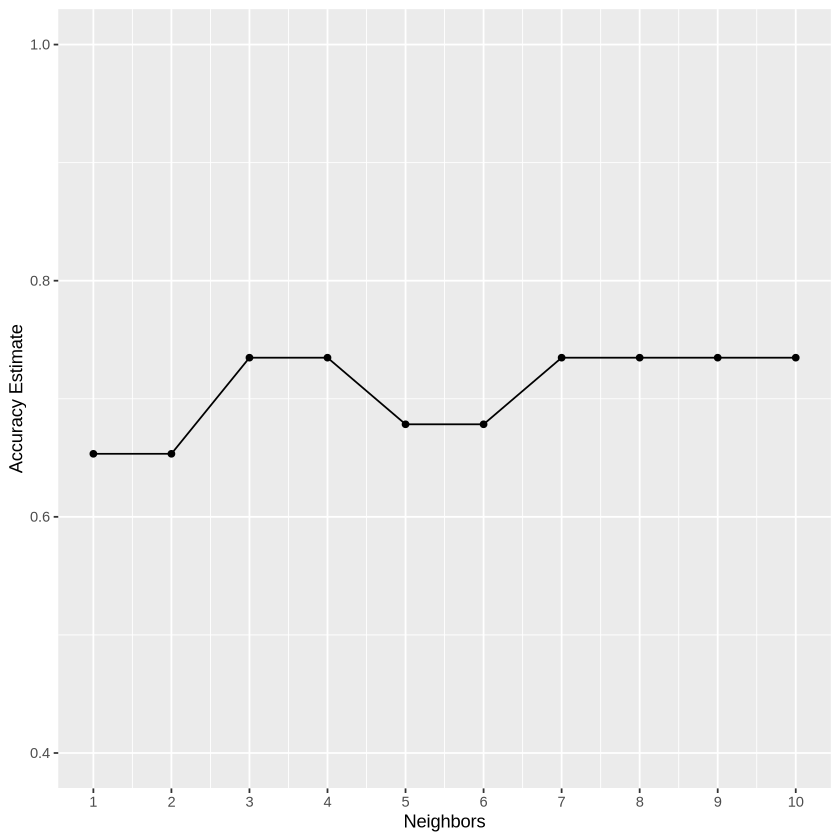

In [105]:
#experience
set.seed(1234)
play_recipe_3 <- recipe(subscribe ~ experience, data = train_split)

play_vfold_3 <- vfold_cv(players, v = 5, strata = subscribe)

play_model_3 <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals_3 <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

play_result_3 <- workflow() |>
add_recipe(play_recipe_3)|>
add_model(play_model_3)|>
tune_grid(resamples = play_vfold, grid = k_vals_3) |>
collect_metrics()

accuracy_3 <- play_result_3 |> 
       filter(.metric == "accuracy")

accuracy_versus_k_3 <- ggplot(accuracy_3, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 

accuracy_versus_k_3
best_k_3 <- accuracy_3 |> 
arrange(desc(mean)) |> 
slice(1)
best_k_3

final_knn_3 <- nearest_neighbor(neighbors = 3, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow_3 <- workflow() |>
  add_recipe(play_recipe) |>
  add_model(final_knn_2)

final_fit_3 <- final_workflow_3 |>
  fit(data = train_split)

test_predictions_3 <- predict(final_fit_3, test_split) |>
  bind_cols(test_split)

metrics_3 <- test_predictions_3 |>
  metrics(truth = subscribe, estimate = .pred_class)

metrics_3

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 38 rows.
               ✖ Assigned data has 39 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 39 to size 38.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.7516953,4,0.02140887,Preprocessor1_Model05


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48979592
kap,binary,0.07686511


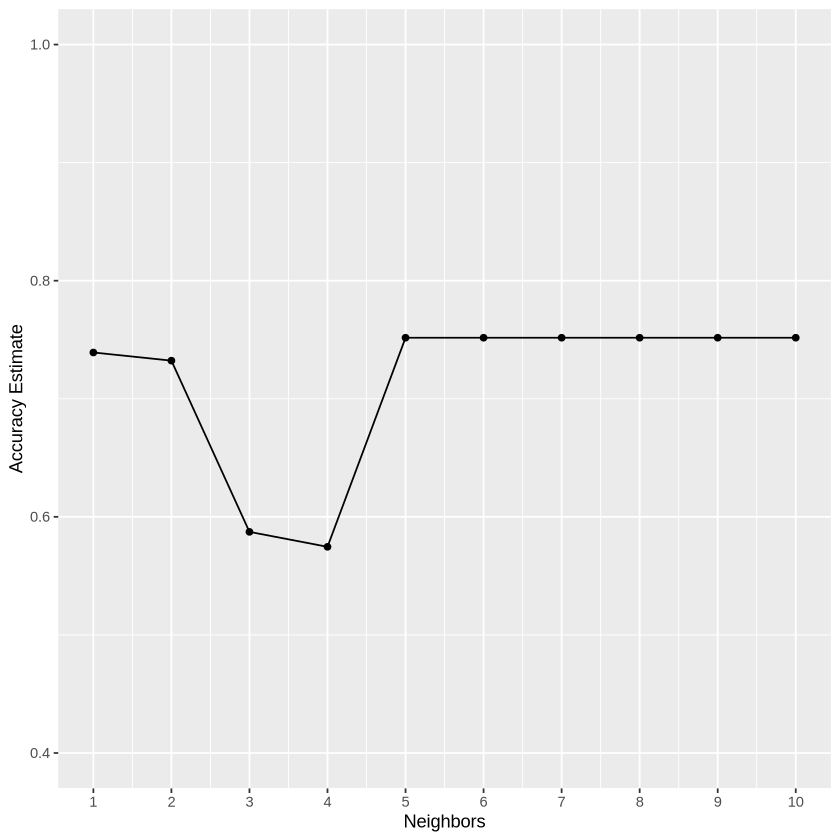

In [107]:
#gender only
set.seed(1234)
play_recipe_4 <- recipe(subscribe ~ gender, data = train_split)

play_vfold_4 <- vfold_cv(players, v = 5, strata = subscribe)

play_model_4 <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals_4 <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

play_result_4 <- workflow() |>
add_recipe(play_recipe_4)|>
add_model(play_model_4)|>
tune_grid(resamples = play_vfold, grid = k_vals_4) |>
collect_metrics()

accuracy_4 <- play_result_4 |> 
       filter(.metric == "accuracy")

accuracy_versus_k_4 <- ggplot(accuracy_4, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 

accuracy_versus_k_4
best_k_4 <- accuracy_4 |> 
arrange(desc(mean)) |> 
slice(1)
best_k_4

final_knn_4 <- nearest_neighbor(neighbor = 5, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow_4 <- workflow() |>
  add_recipe(play_recipe) |>
  add_model(final_knn_4)

final_fit_4 <- final_workflow_4 |>
  fit(data = train_split)

test_predictions_4 <- predict(final_fit_4, test_split) |>
  bind_cols(test_split)

metrics_4 <- test_predictions_4 |>
  metrics(truth = subscribe, estimate = .pred_class)

metrics_4

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 38 rows.
               ✖ Assigned data has 39 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 39 to size 38.

There were issues with some computations   A: x1

→ B | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 37 rows.
               ✖ Assigned data has 38 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 38 to size 37.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7732906,3,0.01298154,Preprocessor1_Model07


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.48979592
kap,binary,0.04371585


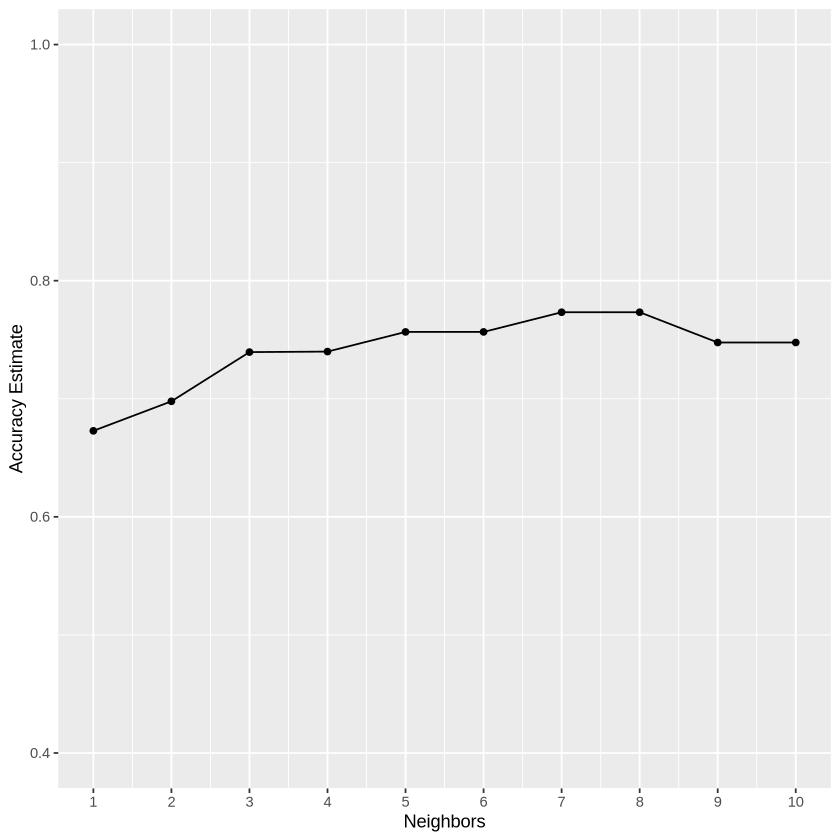

In [109]:
set.seed(1234)
play_recipe_5 <- recipe(subscribe ~ scaled_Age, data = train_split)

play_vfold_5 <- vfold_cv(players, v = 5, strata = subscribe)

play_model_5 <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals_5 <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

play_result_5 <- workflow() |>
add_recipe(play_recipe_5)|>
add_model(play_model_5)|>
tune_grid(resamples = play_vfold, grid = k_vals_4) |>
collect_metrics()

accuracy_5 <- play_result_5 |> 
       filter(.metric == "accuracy")

accuracy_versus_k_5 <- ggplot(accuracy_5, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
       scale_y_continuous(limits = c(0.4, 1.0)) 

accuracy_versus_k_5
best_k_5 <- accuracy_5 |> 
arrange(desc(mean)) |> 
slice(1)
best_k_5

final_knn_5 <- nearest_neighbor(neighbors = 7, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow_5 <- workflow() |>
  add_recipe(play_recipe) |>
  add_model(final_knn_5)

final_fit_5 <- final_workflow_5 |>
  fit(data = train_split)

test_predictions_5 <- predict(final_fit_5, test_split) |>
  bind_cols(test_split)

metrics_5 <- test_predictions_5 |>
  metrics(truth = subscribe, estimate = .pred_class)

metrics_5

In [115]:

library(dplyr)

session_counts <- sessions |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

session_durations <- sessions |>
  mutate(duration_min = (original_end_time - original_start_time) / 60000) |>
  group_by(hashedEmail) |>
  summarise(avg_duration = mean(duration_min, na.rm = TRUE))
library(dplyr)

players_with_sessions <- players |>
  left_join(session_counts, by = "hashedEmail") |>
  left_join(session_durations, by = "hashedEmail")

players_with_sessions


experience,subscribe,hashedEmail,played_hours,name,gender,Age,scaled_played_hours,scaled_Age,num_sessions,avg_duration
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<int>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,0.86235447,-1.86578776,27,74.07407
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,-0.07214775,-0.57017138,3,55.55556
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,-0.20615184,-0.57017138,1,0.00000
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,-0.18146687,0.07763681,1,0.00000
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,-0.20262541,0.07763681,1,0.00000
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,-0.20615184,-0.57017138,NA,NA
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,-0.20615184,-0.24626729,NA,NA
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,-0.20615184,0.07763681,1,0.00000
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,-0.20262541,-0.57017138,1,0.00000


In [111]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age,scaled_played_hours,scaled_Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,"<dbl[,1]>","<dbl[,1]>"
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,0.86235447,-1.86578776
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,-0.07214775,-0.57017138
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,-0.20615184,-0.57017138
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,-0.18146687,0.07763681
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,-0.20262541,0.07763681
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,-0.20615184,-0.57017138
Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19,-0.20615184,-0.24626729
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21,-0.20615184,0.07763681
Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,17,-0.20262541,-0.57017138
